In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
x_data = np.load('X_train.npy')
y_data = np.load('Y_train.npy')

In [3]:
def get_description(label):
    options = ['Normal',
               'Begnign Calcification',
               'Malignant Calcification',
               'Benign Mass',
               'Malignant Mass']
    
    return options[np.argmax(label)]

In [4]:
def get_binary_class(label):
    malignant_vector = [0,0,1,0,1]
    is_malignant = np.sum(label*malignant_vector)
    return np.array([1-is_malignant, is_malignant])

In [5]:
x_data.shape, x_data.dtype, x_data.min(), x_data.max()

((10713, 256, 256), dtype('float64'), 0.0, 255.0)

In [6]:
y_data.shape, y_data.dtype, y_data.min(), y_data.max()

((10713, 5), dtype('float64'), 0.0, 1.0)

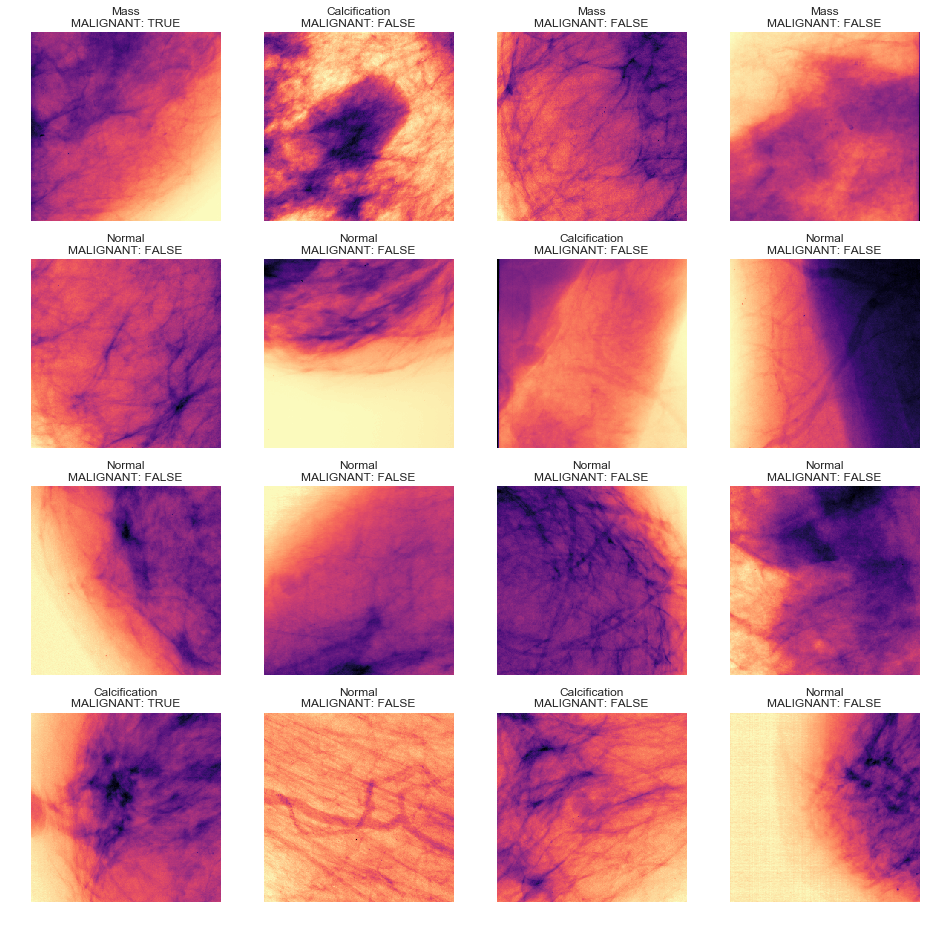

In [7]:
fig = plt.figure(figsize=(16,16))
for i in range(16):
    idx = np.random.randint(0,x_data.shape[0])
    ax = fig.add_subplot(4,4,i+1)
    plt.imshow(255-x_data[idx], cmap='magma')
    plt.title(get_description(y_data[idx]).split()[-1] + '\nMALIGNANT: ' + str(bool(get_binary_class(y_data[idx])[1])).upper())
    plt.axis('off');

In [8]:
y_data_binary = np.apply_along_axis(get_binary_class, axis=1, arr=y_data)
y_data_binary.shape

(10713, 2)

In [9]:
x_data_3chan = np.empty(shape=(*x_data.shape,3))
for i in tqdm(range(x_data.shape[0])):
    x_data_3chan[i,...,0] = x_data[i]
    x_data_3chan[i,...,1] = x_data[i]    
    x_data_3chan[i,...,2] = x_data[i]

100%|██████████| 10713/10713 [00:14<00:00, 736.54it/s]


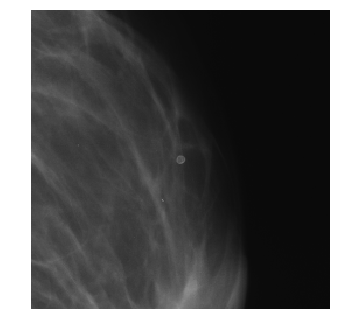

In [10]:
plt.imshow(x_data_3chan[42].astype(np.uint8))
plt.axis('off');

In [11]:
from sklearn.cross_validation import train_test_split

/Users/davidloving/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [34]:
x_train, x_test, y_train, y_test = train_test_split(x_data_3chan, y_data_binary, random_state=42)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8034, 256, 256, 3), (8034, 2), (2679, 256, 256, 3), (2679, 2))

In [13]:
from sklearn.metrics import confusion_matrix
import itertools

# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.arange(2), np.argmax(y_train, axis=1))
class_weights

array([0.60799152, 2.8149965 ])

In [15]:
from keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, AlphaDropout, GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [17]:
def clf_model(input_shape, n_classes, pool=False):
    
    x_in = Input(shape=input_shape)
    if pool:
        x = GlobalMaxPooling2D()(x_in)
        x = BatchNormalization()(x)
    else:
        x = BatchNormalization()(x_in)
        
    x = Dense(1024, activation='selu', kernel_initializer='lecun_normal')(x)
    x = AlphaDropout(0.5)(x)
    x = Dense(256, activation='selu', kernel_initializer='lecun_normal')(x)    
    x = AlphaDropout(0.5)(x)
    x = Dense(64, activation='selu', kernel_initializer='lecun_normal')(x)    
    x = AlphaDropout(0.5)(x)
    x = Dense(n_classes, activation='softmax')(x)
    
    return Model(x_in, x)

# VGG16

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from keras.optimizers import Adam

x_train_v16 = vgg16_preprocess(x_train.copy(), mode='tf')
x_test_v16 = vgg16_preprocess(x_test.copy(), mode='tf')

vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=x_train[0].shape, pooling='max')

x_train_vgg_activations = vgg16_model.predict(x_train_v16, verbose=1)
x_test_vgg_activations = vgg16_model.predict(x_test_v16, verbose=1)

clf = clf_model(x_train_vgg_activations[0].shape, y_train.shape[1])

clf.compile(optimizer=Adam(amsgrad=True), loss='categorical_crossentropy', metrics=['acc'])

history = clf.fit(x = x_train_vgg_activations,
                  y = y_train,
                  epochs = 500,
                  batch_size=64,
                  validation_data = (x_test_vgg_activations, y_test),
                  class_weight=class_weights
                 )

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend();

preds =  clf.predict(x_test_v16, batch_size=32)[:,1]

cnf_matrix = confusion_matrix(y_test[:,1], preds > 0.1)
plot_confusion_matrix(cnf_matrix, ['Normal','Malignant'], normalize=True)
plt.grid(False);

vgg16_model_intermediate = Model(vgg16_model.input, vgg16_model.layers[14].output)

x_train_feats = vgg16_model_intermediate.predict(x_train_v16, batch_size=128, verbose=True)
x_test_feats = vgg16_model_intermediate.predict(x_test_v16, batch_size=128, verbose=True)

clf = clf_model(x_train_feats.shape[1:])

clf.summary()

clf.compile(optimizer=Adam(amsgrad=True), loss='binary_crossentropy', metrics=['acc'])

history = clf.fit(x = x_train_feats,
                  y = y_train,
                  epochs = 500,
                  batch_size=128,
                  validation_data = (x_test_feats, y_test),
                  class_weight=class_weights
                 )

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend();

preds =  clf.predict(x_test_feats, batch_size=12000)[:,1]

cnf_matrix = confusion_matrix(y_test[:,1], preds > 0.1)
plot_confusion_matrix(cnf_matrix, ['Normal','Malignant'], normalize=True)
plt.grid(False);

# ResNet 50

from keras.applications.resnet50 import ResNet50, preprocess_input

x_train_resnet = preprocess_input(x_train.copy(), mode='tf')
x_test_resnet = preprocess_input(x_test.copy(), mode='tf')

x_train_resnet.min(), x_train_resnet.max()

resnet_model = ResNet50(include_top=False, input_shape=x_train[0].shape, pooling='max')

x_train_feats_resnet = resnet_model.predict(x_train_resnet, batch_size=128, verbose=True)
x_test_feats_resnet = resnet_model.predict(x_test_resnet, batch_size=128, verbose=True)

clf_resnet = clf_model(x_train_feats_resnet[0].shape, y_train.shape[1], pool=False)
clf_resnet.compile(optimizer=Adam(amsgrad=True), loss='categorical_crossentropy', metrics=['acc'])

history = clf_resnet.fit(x = x_train_feats_resnet,
                         y = y_train,
                         epochs = 50,
                         batch_size=32,
                         validation_data = (x_test_feats_resnet, y_test),
                         class_weight=class_weights
                        )

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend();

preds =  clf_resnet.predict(x_test_feats_resnet, batch_size=12000)[:,1]

cnf_matrix = confusion_matrix(y_test[:,1], preds > 0.1)
plot_confusion_matrix(cnf_matrix, ['Normal','Malignant'], normalize=True)
plt.grid(False);

resnet_model = ResNet50(include_top=True, weights=None, input_shape=x_train[0].shape, classes=y_train.shape[1])

resnet_model.compile(optimizer=Adam(amsgrad=True), loss='binary_crossentropy', metrics=['acc'])

checkpoint = ModelCheckpoint('checkpoint_b.hdf5', save_best_only=True)

resnet_model.fit(x=x_train_resnet,
                 y=y_train,
                 epochs=150,
                 batch_size=32,
                 validation_data=(x_test_resnet, y_test),
                 class_weight=class_weights,
                 callbacks=[checkpoint])

resnet_model.load_weights('checkpoint.hdf5')

preds =  resnet_model.predict(x_test_resnet, batch_size=64, verbose=True)

preds_malig = preds[:,2] + preds[:,4]

cnf_matrix = confusion_matrix(y_test[:,1], preds_malig > 0.4)
plot_confusion_matrix(cnf_matrix, ['Normal','Malignant'], normalize=True)
plt.grid(False);

from sklearn.metrics import roc_curve, auc

# adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr, tpr, _ = roc_curve(y_test[:,1], preds_malig)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# InceptionResNetV2

In [25]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

In [19]:
x_train_nasnet = preprocess_input(x_train.copy())
x_test_nasnet = preprocess_input(x_test.copy())

x_train_nasnet.min(), x_train_nasnet.max()

(-1.0, 1.0)

inresv2_model = InceptionResNetV2(include_top=False, pooling='max')

x_train_feats_inresv2 = inresv2_model.predict(x_train_nasnet, batch_size=128, verbose=True)
x_test_feats_inresv2 = inresv2_model.predict(x_test_nasnet, batch_size=128, verbose=True)

clf_inresv2 = clf_model(x_train_feats_inresv2[0].shape, 2, pool=False)
clf_inresv2.compile(optimizer=Adam(amsgrad=True), loss='categorical_crossentropy', metrics=['acc'])

history = clf_inresv2.fit(x = x_train_feats_inresv2,
                         y = y_train,
                         epochs = 50,
                         batch_size=128,
                         validation_data = (x_test_feats_inresv2, y_test),
                         class_weight=class_weights
                        )

In [62]:
from keras.optimizers import SGD

In [38]:
inresv2_model_b = InceptionResNetV2(include_top=True, weights=None, classes=2)

In [67]:
inresv2_model_b.compile(optimizer=SGD(lr=0.01), loss='categorical_crossentropy', metrics=['acc'])

In [75]:
checkpoint = ModelCheckpoint('checkpoint_bbbb.hdf5', save_best_only=True)

history = inresv2_model_b.fit(x=x_train_nasnet,
                             y=y_train,
                             epochs=15,
                             batch_size=32,
                             validation_data=(x_test_nasnet, y_test),
                             class_weight=class_weights,
                             callbacks=[checkpoint])

Train on 8034 samples, validate on 2679 samples
Epoch 1/15
8034/8034 [==============================] - 321s 40ms/step - loss: 0.3035 - acc: 0.8703 - val_loss: 0.3814 - val_acc: 0.8391
Epoch 2/15
8034/8034 [==============================] - 279s 35ms/step - loss: 0.3029 - acc: 0.8729 - val_loss: 0.3921 - val_acc: 0.8425
Epoch 3/15
8034/8034 [==============================] - 280s 35ms/step - loss: 0.2988 - acc: 0.8712 - val_loss: 0.3870 - val_acc: 0.8410
Epoch 4/15
8034/8034 [==============================] - 280s 35ms/step - loss: 0.3046 - acc: 0.8678 - val_loss: 0.3850 - val_acc: 0.8365
Epoch 5/15
8034/8034 [==============================] - 280s 35ms/step - loss: 0.3016 - acc: 0.8733 - val_loss: 0.3833 - val_acc: 0.8402
Epoch 6/15
8034/8034 [==============================] - 280s 35ms/step - loss: 0.3019 - acc: 0.8697 - val_loss: 0.3842 - val_acc: 0.8395
Epoch 7/15
8034/8034 [==============================] - 280s 35ms/step - loss: 0.3013 - acc: 0.8694 - val_loss: 0.3864 - val_acc: 

In [76]:
inresv2_model_b.load_weights('checkpoint_bbbb.hdf5')

In [77]:
preds =  inresv2_model_b.predict(x_test_nasnet, batch_size=64, verbose=True)

2679/2679 [==============================] - 29s 11ms/step


Normalized confusion matrix
[[0.94037324 0.05962676]
 [0.62240664 0.37759336]]


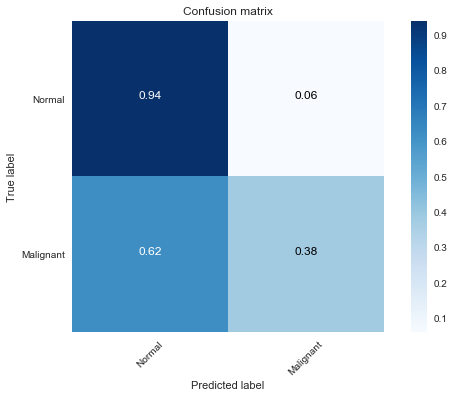

In [78]:
cnf_matrix = confusion_matrix(y_test[:,1], preds[:,1] > 0.5)
plot_confusion_matrix(cnf_matrix, ['Normal','Malignant'], normalize=True)
plt.grid(False);

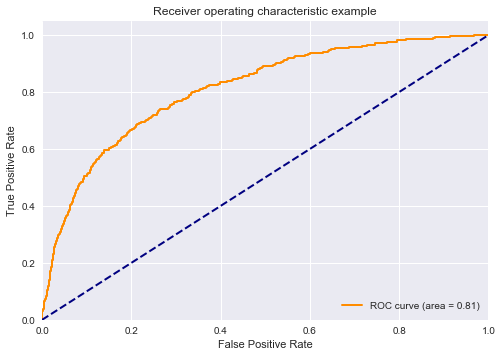

In [79]:
from sklearn.metrics import roc_curve, auc

# adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr, tpr, _ = roc_curve(y_test[:,1], preds[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [80]:
preds =  inresv2_model_b.predict(x_train_nasnet, batch_size=64, verbose=True)

8034/8034 [==============================] - 83s 10ms/step


Normalized confusion matrix
[[0.96095051 0.03904949]
 [0.51716889 0.48283111]]


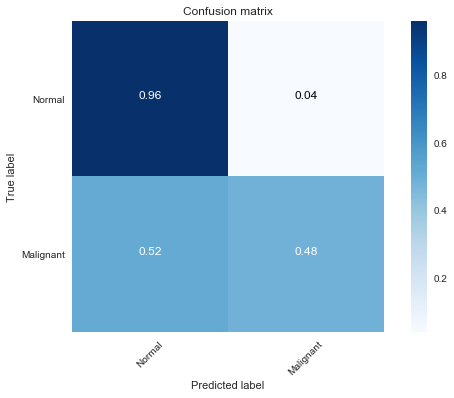

In [81]:
cnf_matrix = confusion_matrix(y_train[:,1], preds[:,1] > 0.5)
plot_confusion_matrix(cnf_matrix, ['Normal','Malignant'], normalize=True)
plt.grid(False);

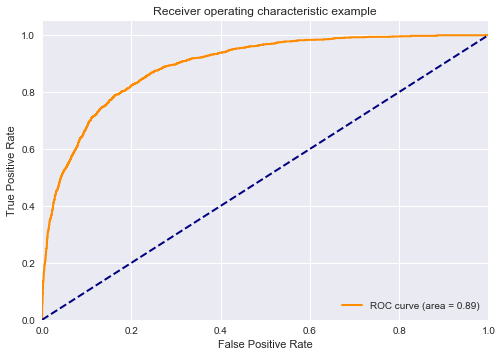

In [82]:
from sklearn.metrics import roc_curve, auc

# adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr, tpr, _ = roc_curve(y_train[:,1], preds[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [83]:
all_preds = inresv2_model_b.predict(preprocess_input(x_data_3chan.copy()), verbose=1)

10713/10713 [==============================] - 114s 11ms/step


In [84]:
np.save('last_preds.npy', all_preds)